# Introductory Example

This demonstrates an example using scalecast `0.18.0`. Several features explored are not available in earlier versions, so if anything is not working, try upgrading:

`pip install --upgrade scalecast`

If things are still not working, you spot a typo, or you have some other suggestion to improve functionality or document readability, open an [issue](https://github.com/mikekeith52/scalecast/issues/new) or email mikekeith52@gmail.com.

Link to dataset used in this example: https://www.kaggle.com/datasets/neuromusic/avocado-prices.  

Link to other examples: https://github.com/mikekeith52/scalecast-examples

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read in data
data = pd.read_csv('avocado.csv',parse_dates = ['Date'])
data = data.sort_values(['region','type','Date'])

[Univariate Forecasting](#Univariate-Forecasting)  
[Multivariate Forecasting](#Multivariate-Forecasting)  
[Transformations](#Transformations)  
[Pipelines](#Pipelines)  
[Fully Automated Pipelines](#Fully-Automated-Pipelines)  
[Scaled Automated Forecasting](#Scaled-Automated-Forecasting)  
[Exporting Results](#Exporting-Results)  

## Univariate Forecasting

### Load the `Forecaster` Object
- This is an object that can store data, run forecasts, store results, and plot. It's a UI, procedure, and set of models all-in-one.
- Forecasts in scalecast are run with a dynamic recursive approach by default, as opposed to a direct or other approach.
- [Forecaster Object Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html).

In [3]:
from scalecast.Forecaster import Forecaster

In [4]:
volume = data.groupby('Date')['Total Volume'].sum()

In [5]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = 13,
)

f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Exploratory Data Analysis

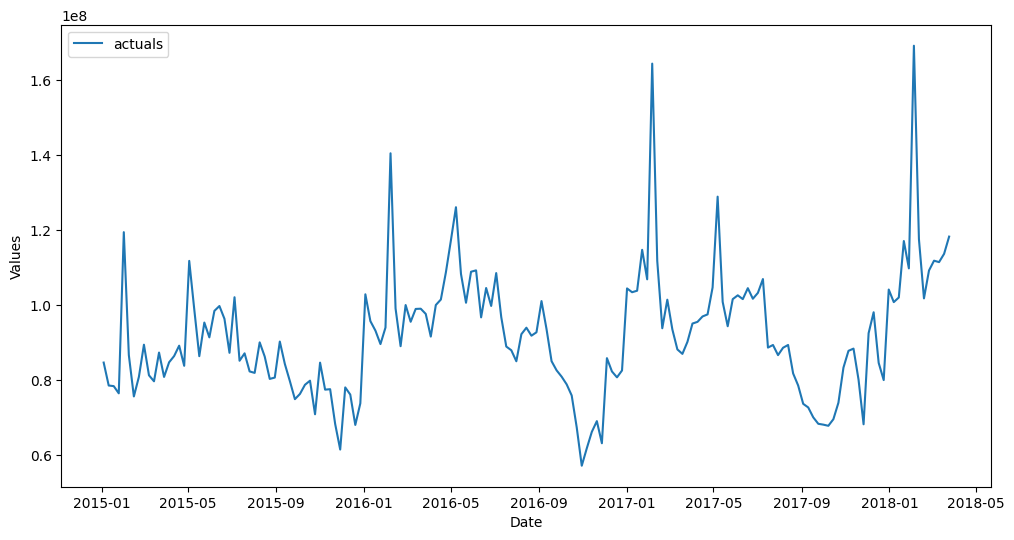

In [6]:
f.plot()
plt.show()

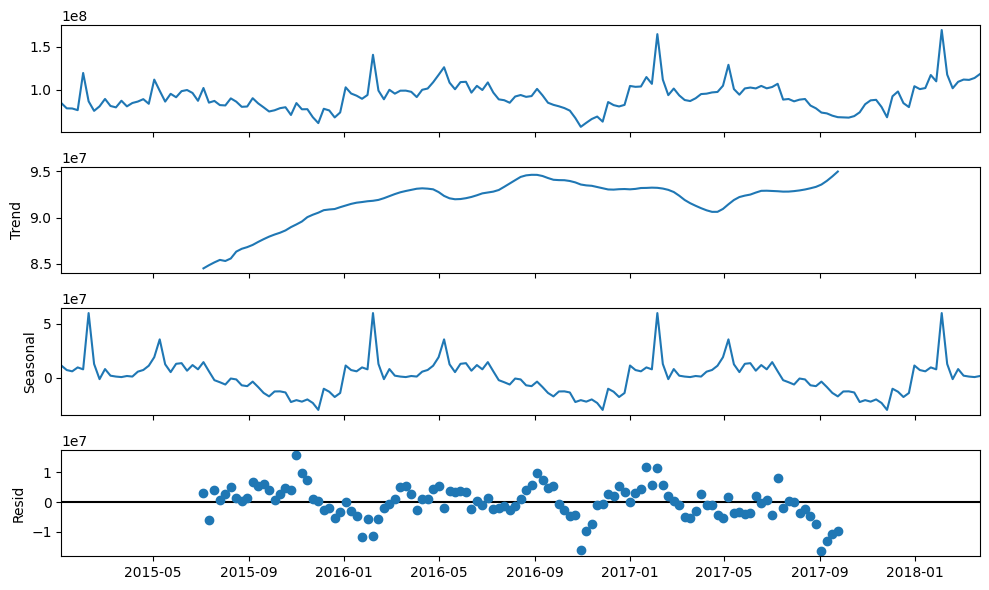

In [7]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

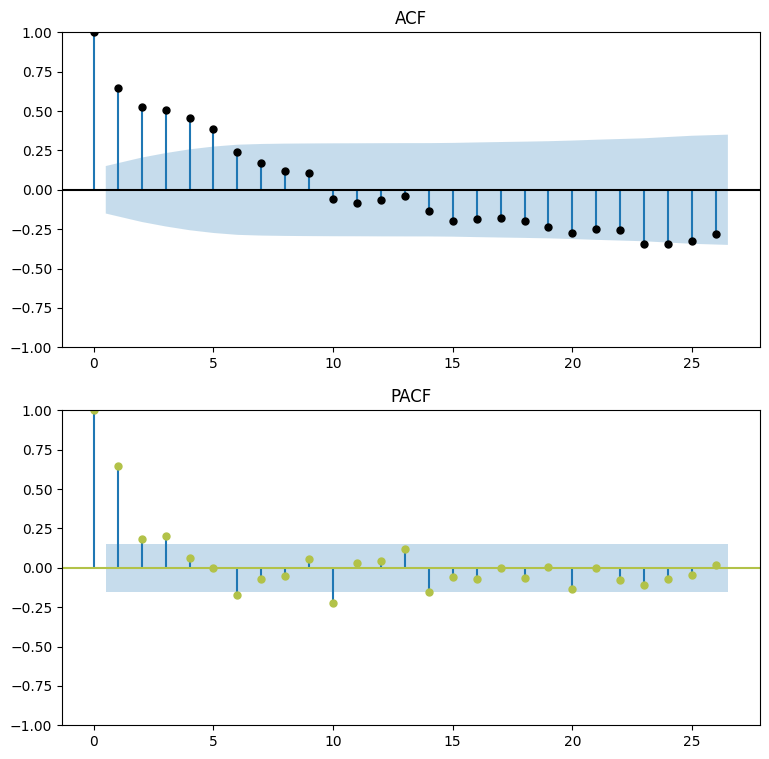

In [8]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF',lags=26,color='black')
f.plot_pacf(ax=axs[1],title='PACF',lags=26,color='#B2C248',method='ywm')
plt.show()

### Parameterize the `Forecaster` Object

#### Set Test Length
- Starting in scalecast version 0.16.0, you can skip model testing by setting a test length of 0.
- In this example, all models will be tested on the last 15% of the observed values in the dataset.

In [9]:
f.set_test_length(.15)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

#### Tell the Object to Evaluate Confidence Intervals
- This only works if there is a test set specified and it is of a sufficient size.
- See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.eval_cis).
- See the [example](https://scalecast-examples.readthedocs.io/en/latest/misc/cis/cis.html).

In [10]:
# default args below
f.eval_cis(
    mode = True, # tell the object to evaluate intervals
    cilevel = .95, # 95% confidence level
)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

#### Specify Model Inputs

##### Trend

In [11]:
f.add_time_trend()

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t']
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

##### Seasonality

In [12]:
f.add_seasonal_regressors('week',raw=False,sincos=True)

##### Autoregressive Terms / Series Lags

In [13]:
f.add_ar_terms(13)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos', AR(lag_order=1), AR(lag_order=2), AR(lag_order=3), AR(lag_order=4), AR(lag_order=5), AR(lag_order=6), AR(lag_order=7), AR(lag_order=8), AR(lag_order=9), AR(lag_order=10), AR(lag_order=11), AR(lag_order=12), AR(lag_order=13)]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

### Run Models
- See the [available models](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html).
- See the [blog post](https://medium.com/towards-data-science/expand-your-time-series-arsenal-with-these-models-10c807d37558).
- The `dynamic_testing` argument for all of these will be 13 -- test-set results will then be in terms of rolling averages of 13-step forecasts, which is also our forecast length.
- The resulting forecasts from this process are not well-fit. Better forecasts are obtained once more optimization is performed in later sections.

#### Linear Scikit-Learn Models

In [14]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=13)

[111925329.05919902,
 121868567.62128672,
 99242683.29670584,
 105678887.13113496,
 112308203.89056405,
 120678154.74020165,
 116651150.57302916,
 109280118.5937806,
 112349081.07925618,
 109439809.17344558,
 110071156.63943002,
 101942075.08718517,
 105855231.06833494]

In [15]:
f.set_estimator('lasso')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

[111925345.03515089,
 121868543.75811641,
 99242690.97795567,
 105678895.70507629,
 112308214.10968,
 120678152.00122349,
 116651130.64591944,
 109280120.05952653,
 112349068.95905633,
 109439806.52890718,
 110071134.3376767,
 101942075.85864875,
 105855227.63866332]

In [16]:
f.set_estimator('ridge')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

[112274660.61929211,
 119418913.83741269,
 101042044.25944778,
 105727082.8076545,
 112062324.78367472,
 119544283.79214948,
 114434064.88122699,
 109083035.43914786,
 111016311.82109724,
 108835849.31780478,
 108575648.39289793,
 102768196.78693625,
 105049882.09154823]

In [17]:
f.set_estimator('elasticnet')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

[105685629.29640055,
 105281381.8744145,
 103215061.54035863,
 102649894.23494358,
 102879280.27984047,
 102902501.47034767,
 101898337.98197824,
 101102145.44408616,
 100388037.21838164,
 99432772.90679798,
 98765481.90172084,
 98088863.2782056,
 97329749.89139286]

In [18]:
f.set_estimator('sgd')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

[112488583.94456536,
 112460951.60689813,
 111684191.6186549,
 111556878.43748277,
 111120237.74731848,
 110843484.75751875,
 107561877.32718572,
 106195599.61682358,
 105459919.1877728,
 104336449.31637973,
 103156046.77842753,
 101994240.04906143,
 100751886.06726637]

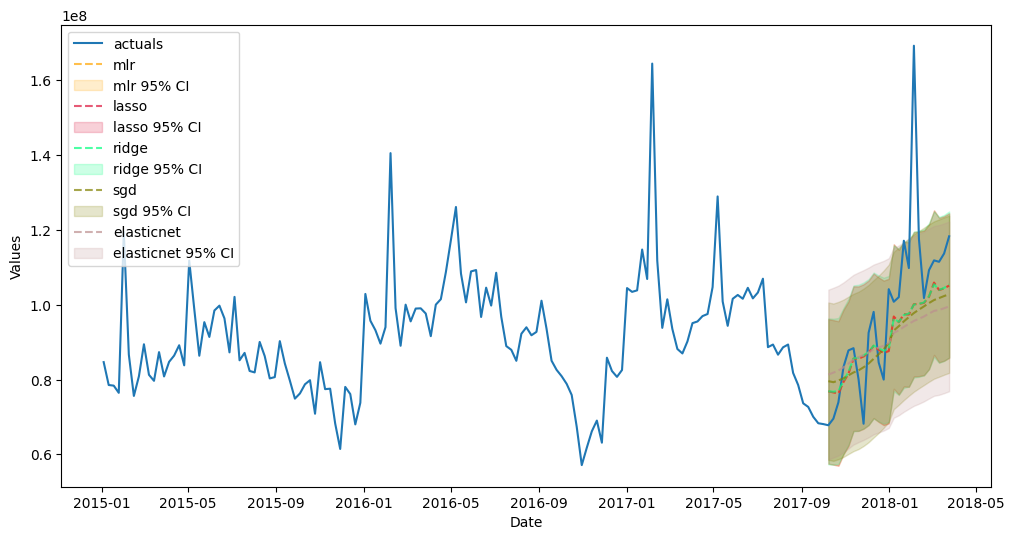

In [19]:
f.plot_test_set(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='TestSetRMSE')
plt.show()

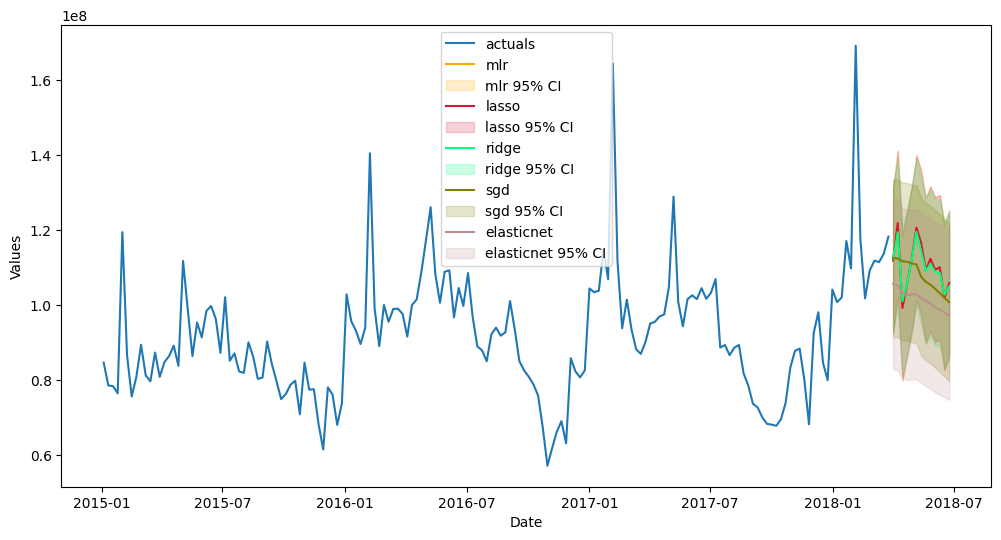

In [20]:
f.plot(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='TestSetRMSE')
plt.show()

#### Non-linear Scikit-Learn Models

In [21]:
f.set_estimator('rf')
f.manual_forecast(max_depth=2,dynamic_testing=13)

[106292381.75416553,
 106003730.04583386,
 105585766.31796177,
 105134863.05164418,
 105134863.05164418,
 105606099.42685245,
 105325836.37960312,
 105134863.05164418,
 105134863.05164418,
 105134863.05164418,
 105134863.05164418,
 105134863.05164418,
 105325836.37960312]

In [22]:
f.set_estimator('gbt')
f.manual_forecast(max_depth=2,dynamic_testing=13)

[115938308.61096564,
 115399347.50638327,
 116570947.86813788,
 118027393.92171198,
 123612174.58197817,
 121691783.88882585,
 110827352.09286179,
 114377771.97877876,
 112453200.90496303,
 115419115.00078678,
 112453200.90496303,
 116847689.17197251,
 115385430.09892905]

In [23]:
f.set_estimator('xgboost')
f.manual_forecast(gamma=1,dynamic_testing=13)

[116980180.0,
 115641280.0,
 116674830.0,
 119585820.0,
 117081500.0,
 127788610.0,
 117303300.0,
 103215230.0,
 108198220.0,
 108097260.0,
 106283944.0,
 109226060.0,
 116995064.0]

In [24]:
f.set_estimator('catboost')
f.manual_forecast(depth=4,verbose=False,dynamic_testing=13)

[116846314.39195865,
 114782872.13859823,
 115526880.62077451,
 112943011.8195494,
 118833386.8812325,
 118462895.75596091,
 110523264.47436357,
 111988737.59071368,
 112226803.30083351,
 111621609.22791208,
 111429705.42153662,
 110663502.60068737,
 109363815.35791725]

In [25]:
f.set_estimator('knn')
f.manual_forecast(n_neighbors=5,dynamic_testing=13)

[104376279.50799999,
 106889207.4,
 100185057.636,
 98687859.784,
 100107069.238,
 109220441.306,
 102384289.098,
 102155557.60800001,
 100432864.052,
 97987550.39,
 94980742.072,
 95231419.28400001,
 93919469.74599999]

In [26]:
f.set_estimator('mlp')
f.manual_forecast(hidden_layer_sizes=(50,50),solver='lbfgs',dynamic_testing=13)

[108098499.50319642,
 114878364.60304695,
 112192468.75243324,
 112436336.7663157,
 116989651.05412666,
 122449890.62875707,
 116732597.9354999,
 115442882.79053544,
 116118546.14440638,
 113690354.9704108,
 113901427.8568513,
 112272462.08469348,
 109390303.05421841]

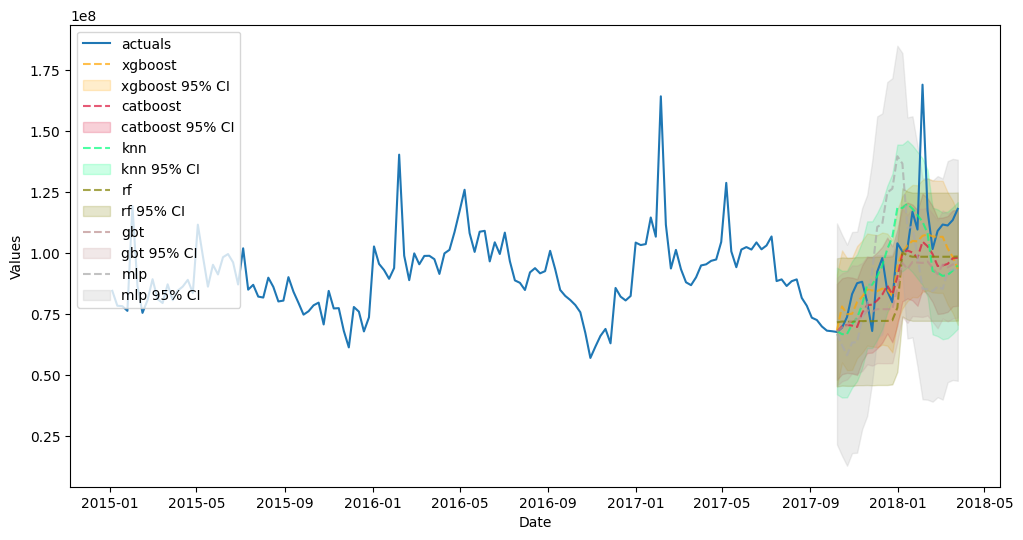

In [27]:
f.plot_test_set(
    ci=True,
    models=['rf','gbt','xgboost','lightgbm','catboost','knn','mlp'],
    order_by='TestSetRMSE'
)
plt.show()

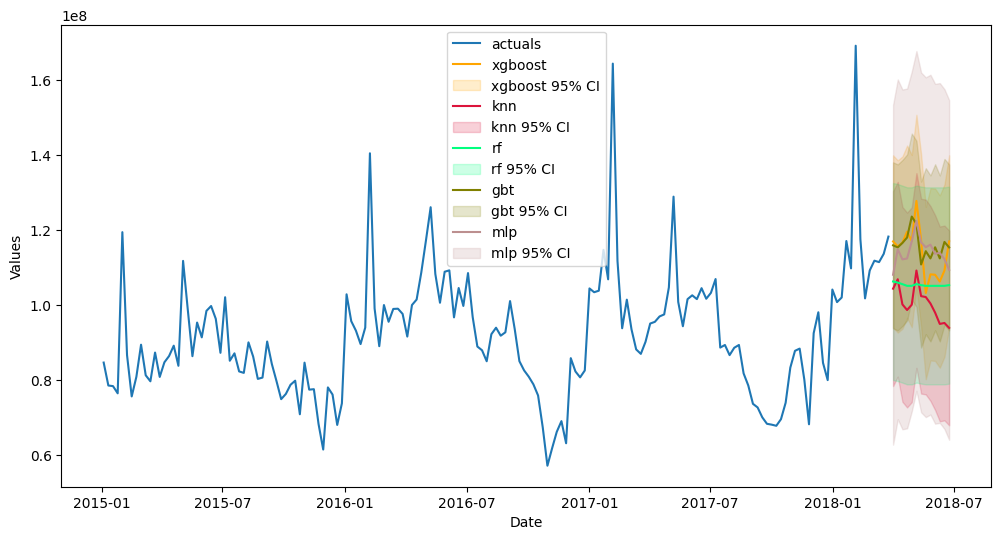

In [28]:
f.plot(ci=True,models=['rf','gbt','xgboost','knn','mlp'],order_by='TestSetRMSE')
plt.show()

#### Stacking Models

##### Sklearn Stacking Model

In [29]:
from sklearn.ensemble import StackingRegressor

In [30]:
f.add_sklearn_estimator(StackingRegressor,'stacking')

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos', AR(lag_order=1), AR(lag_order=2), AR(lag_order=3), AR(lag_order=4), AR(lag_order=5), AR(lag_order=6), AR(lag_order=7), AR(lag_order=8), AR(lag_order=9), AR(lag_order=10), AR(lag_order=11), AR(lag_order=12), AR(lag_order=13)]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=['mlr', 'lasso', 'ridge', 'elasticnet', 'sgd', 'rf', 'gbt', 'xgboost', 'catboost', 'knn', 'mlp']
    CILevel=0.95
    CurrentEstimator=mlp
    GridsFile=Grids
)

In [31]:
estimators = [
    ('elasticnet',f.estimators.lookup_item('elasticnet').imported_model(alpha=0.2)),
    ('xgboost',f.estimators.lookup_item('xgboost').imported_model(gamma=1)),
    ('gbt',f.estimators.lookup_item('gbt').imported_model(max_depth=2)),
]

final_estimator = f.estimators.lookup_item('catboost').imported_model()

f.add_sklearn_estimator(StackingRegressor,'stacking')
f.set_estimator('stacking')
f.manual_forecast(
    estimators=estimators,
    final_estimator=final_estimator,
    dynamic_testing=13,
    call_me='sklearn_stack',
)

Learning rate set to 0.029697
0:	learn: 15104089.1880067	total: 374us	remaining: 374ms
1:	learn: 14912526.5344766	total: 631us	remaining: 315ms
2:	learn: 14711103.7214056	total: 819us	remaining: 272ms
3:	learn: 14506074.4495969	total: 990us	remaining: 247ms
4:	learn: 14314125.2663375	total: 1.18ms	remaining: 235ms
5:	learn: 14121360.6969337	total: 1.41ms	remaining: 233ms
6:	learn: 13949503.6496268	total: 1.59ms	remaining: 226ms
7:	learn: 13762054.3647725	total: 1.83ms	remaining: 227ms
8:	learn: 13587749.7520317	total: 2.09ms	remaining: 230ms
9:	learn: 13408982.7830585	total: 2.27ms	remaining: 224ms
10:	learn: 13232771.4710440	total: 2.43ms	remaining: 218ms
11:	learn: 13082024.3684938	total: 2.63ms	remaining: 216ms
12:	learn: 12936163.9718911	total: 2.79ms	remaining: 212ms
13:	learn: 12784168.4249877	total: 3.03ms	remaining: 214ms
14:	learn: 12660223.3500395	total: 3.2ms	remaining: 210ms
15:	learn: 12510280.1102172	total: 3.45ms	remaining: 212ms
16:	learn: 12380117.6852013	total: 3.64ms

[107678474.10478385,
 108377521.88355981,
 109442140.04786366,
 110186261.05797003,
 117978724.61936066,
 135484148.6024084,
 108984666.83380039,
 131986839.19891399,
 110376396.8988548,
 120112098.0228566,
 112467535.70202649,
 110766275.07484761,
 114139764.06026874]

##### Scalecast Stacking Model

In [32]:
f.add_signals(['elasticnet','xgboost','knn'],train_only=True)
f.set_estimator('catboost')
f.manual_forecast(call_me = 'scalecast_stack',verbose=False)

[114370918.11640924,
 114016247.62424554,
 115033489.37223953,
 113970030.66329396,
 114042622.2036964,
 115123567.68239625,
 112929094.00877601,
 112220435.15175214,
 113633748.55193451,
 113245862.48019421,
 111596901.5275508,
 112700546.59594658,
 110843933.54867446]

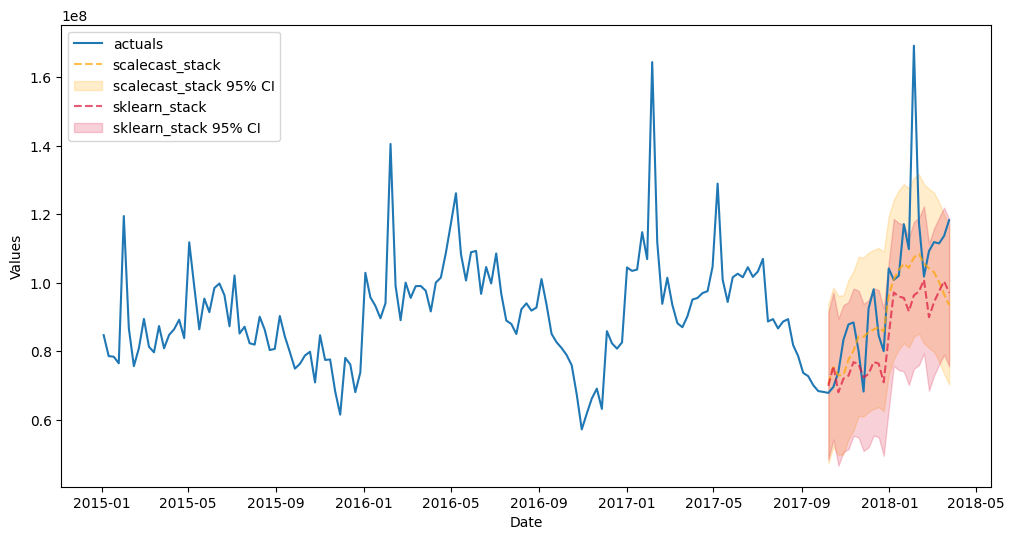

In [33]:
f.plot_test_set(models=['sklearn_stack','scalecast_stack'],ci=True,order_by='TestSetRMSE')
plt.show()

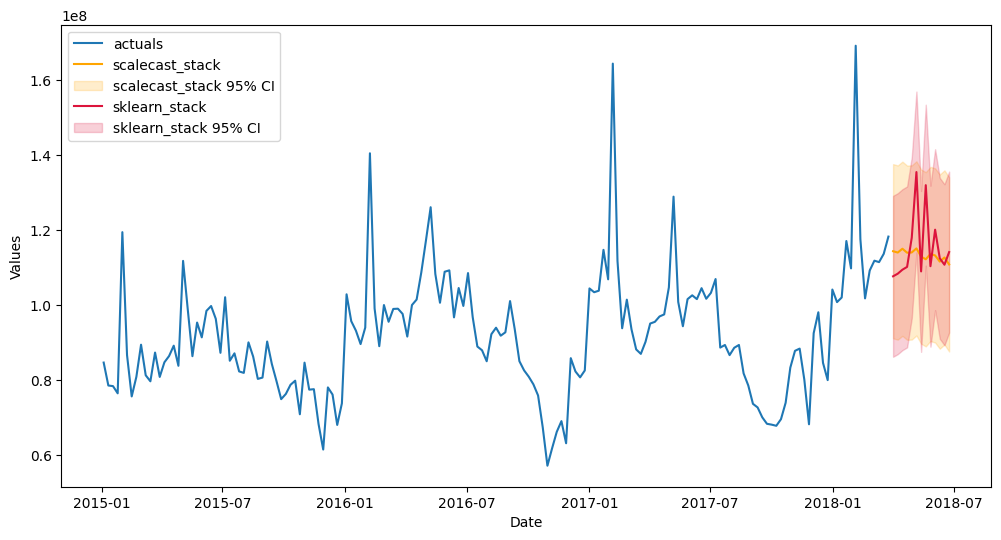

In [34]:
f.plot(models=['sklearn_stack','scalecast_stack'],ci=True,order_by='TestSetRMSE')
plt.show()

#### ARIMA
- [auxmodels.auto_arima](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#module-src.scalecast.auxmodels.auto_arima)

In [35]:
from scalecast.auxmodels import auto_arima

In [36]:
auto_arima(f,m=52)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos', AR(lag_order=1), AR(lag_order=2), AR(lag_order=3), AR(lag_order=4), AR(lag_order=5), AR(lag_order=6), AR(lag_order=7), AR(lag_order=8), AR(lag_order=9), AR(lag_order=10), AR(lag_order=11), AR(lag_order=12), AR(lag_order=13), 'signal_elasticnet', 'signal_xgboost', 'signal_knn']
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=['mlr', 'lasso', 'ridge', 'elasticnet', 'sgd', 'rf', 'gbt', 'xgboost', 'catboost', 'knn', 'mlp', 'sklearn_stack', 'scalecast_stack', 'auto_arima']
    CILevel=0.95
    CurrentEstimator=arima
    GridsFile=Grids
)

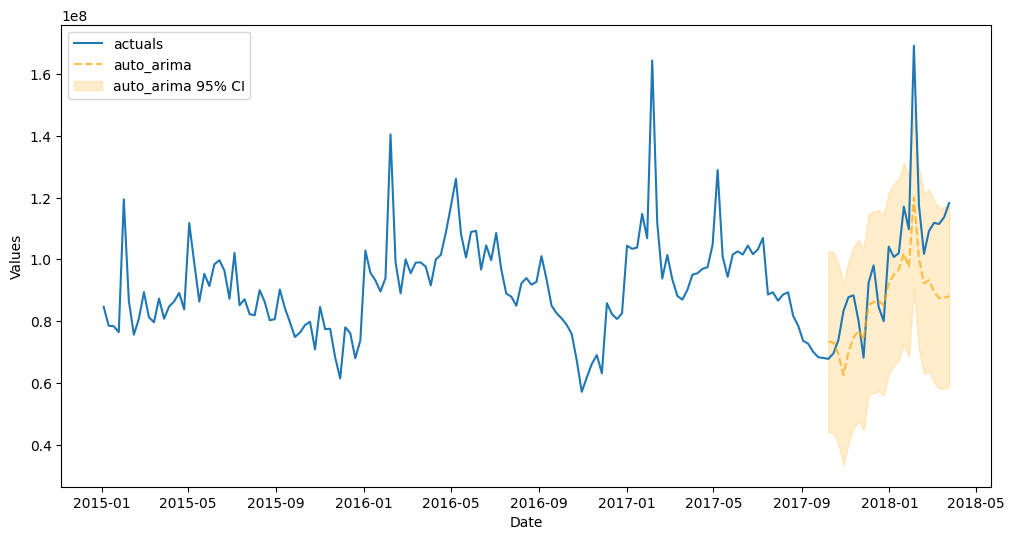

In [37]:
f.plot_test_set(models='auto_arima',ci=True)
plt.show()

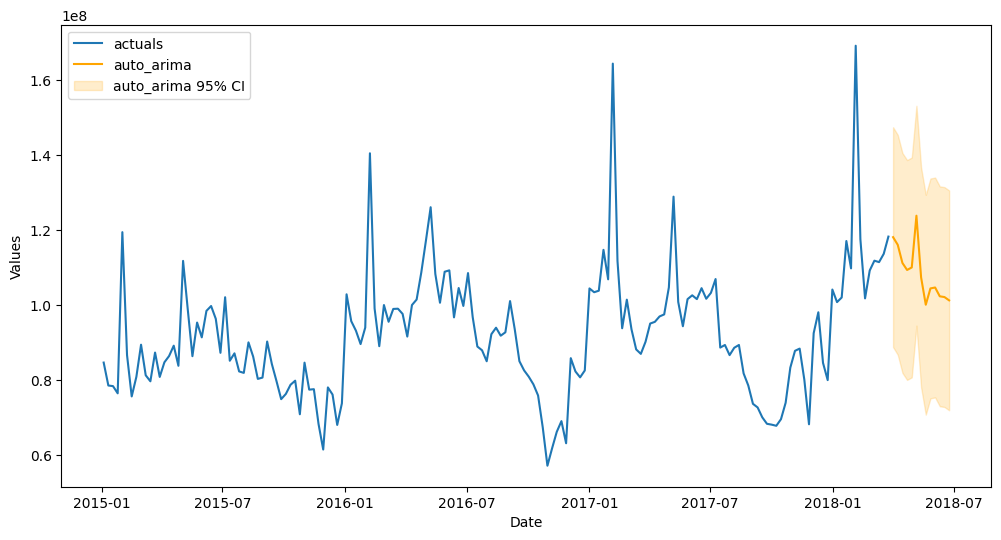

In [38]:
f.plot(models='auto_arima',ci=True)
plt.show()

## Multivariate Forecasting

### Load the `MVForecaster` Object
- This object extends the univariate approach to several series, with many of the same plotting and reporting features available.
- [Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html)

In [39]:
from scalecast.MVForecaster import MVForecaster

In [40]:
price = data.groupby('Date')['AveragePrice'].mean()

fvol = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
fprice = Forecaster(y=price,current_dates=price.index,future_dates=13)

fvol.add_time_trend()
fvol.add_seasonal_regressors('week',raw=False,sincos=True)

mvf = MVForecaster(
    fvol,
    fprice,
    merge_Xvars='union',
    names=['volume','price'],
)

mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=0
    ValidationLength=1
    ValidationMetric=MetricStore(name='rmse', eval_func=<function Metrics.rmse at 0x300c28b80>, lower_is_better=True, min_obs_required=1)
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

### Exploratory Data Analysis

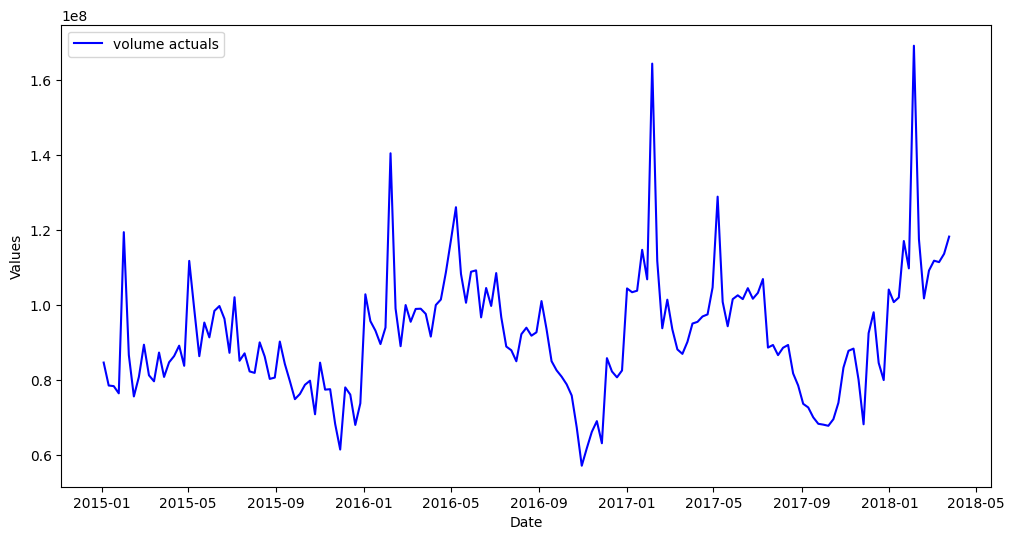

In [41]:
mvf.plot(series='volume')
plt.show()

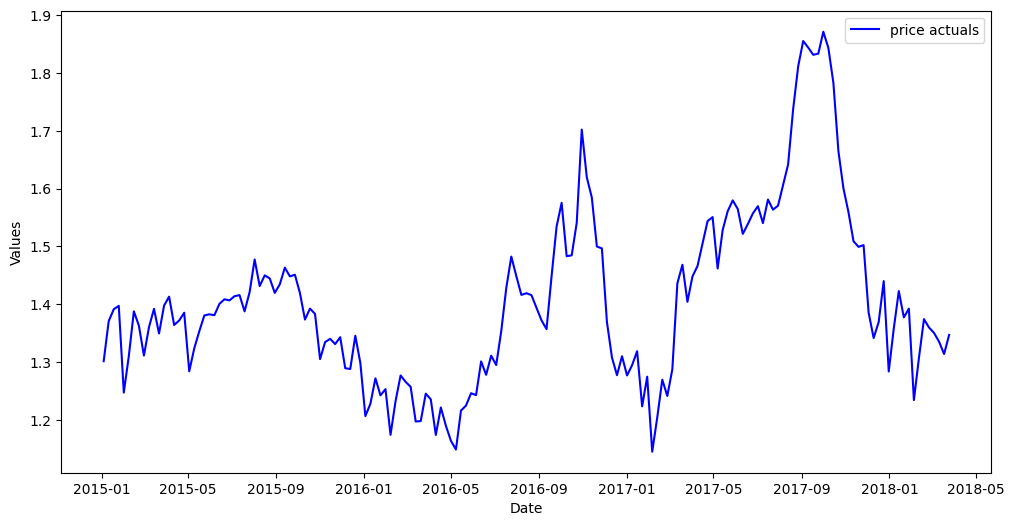

In [42]:
mvf.plot(series='price')
plt.show()

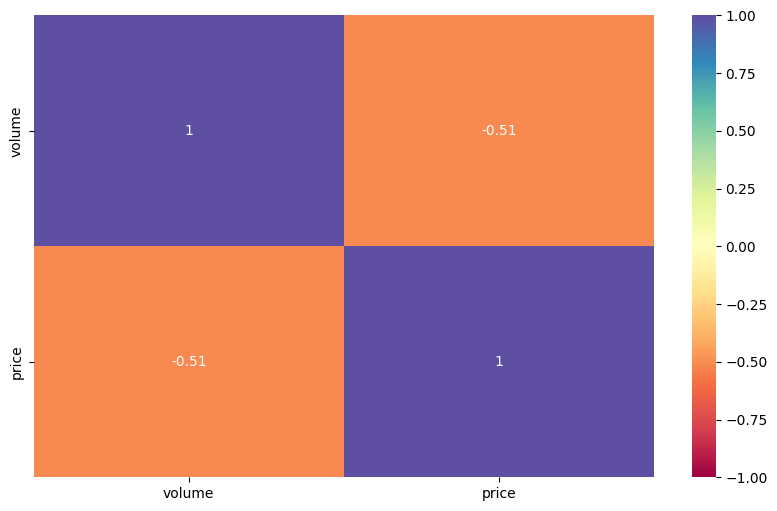

In [43]:
mvf.corr(disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1)
plt.show()

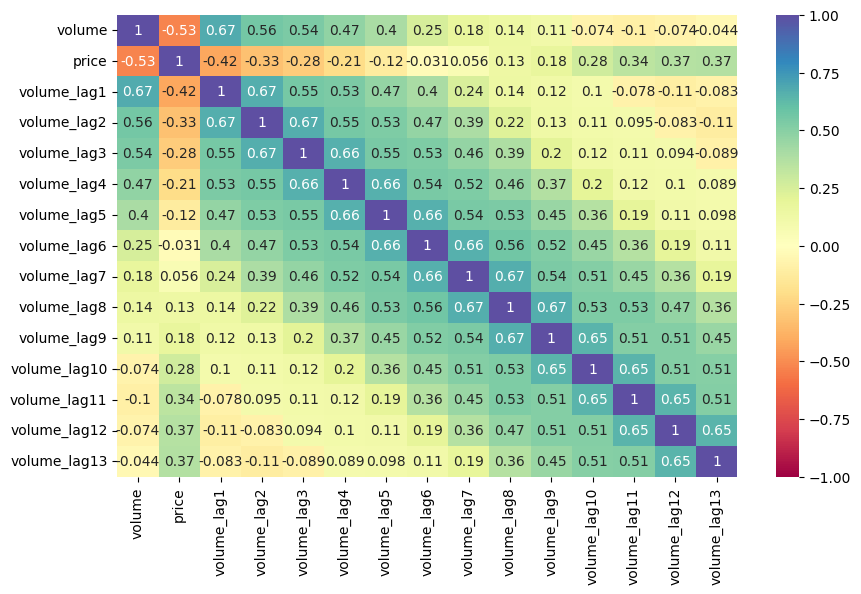

In [44]:
mvf.corr_lags(y='price',x='volume',disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1,lags=13)
plt.show()

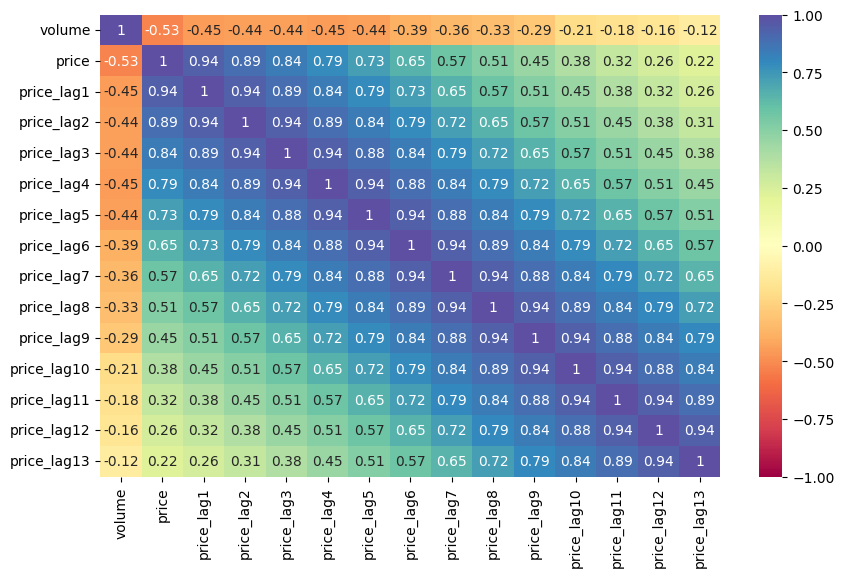

In [45]:
mvf.corr_lags(y='volume',x='price',disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1,lags=13)
plt.show()

### Parameterize the `MVForecaster` Object
- Starting in scalecast version 0.16.0, you can skip model testing by setting a test length of 0.
- In this example, all models will be tested on the last 15% of the observed values in the dataset.
- We will also have model optimization select hyperparemeters based on what predicts the volume series, rather than the price series, or an average of the two (which is the default), best.
- [Custom optimization](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.add_optimizer_func) functions are available.

In [46]:
mvf.set_test_length(.15)
mvf.set_optimize_on('volume') # we care more about predicting volume and price is just used to make those predictions more accurate
# by default, the optimizer uses an average scoring of all series in the MVForecaster object
mvf.eval_cis() # tell object to evaluate cis

mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=25
    ValidationLength=1
    ValidationMetric=MetricStore(name='rmse', eval_func=<function Metrics.rmse at 0x300c28b80>, lower_is_better=True, min_obs_required=1)
    ForecastsEvaluated=[]
    CILevel=0.95
    CurrentEstimator=mlr
    OptimizeOn=volume
    GridsFile=MVGrids
)

### Run Models
- Uses scikit-learn models and APIs only.
- See the adapted [VECM model](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#vecm) for this object.

#### ElasticNet

In [47]:
mvf.set_estimator('elasticnet')
mvf.manual_forecast(alpha=0.2,dynamic_testing=13,lags=13)

{'volume': [106335852.49281684,
  105996760.49615353,
  103764831.76312366,
  103219085.1545862,
  103556174.50935248,
  103631712.71106485,
  102440651.65475722,
  101711752.26293221,
  101107339.59279618,
  100363808.85579453,
  100029026.11427598,
  99652566.48028272,
  99185655.81929666],
 'price': [1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793,
  1.4104745120749793]}

#### XGBoost

In [48]:
mvf.set_estimator('xgboost')
mvf.manual_forecast(gamma=1,dynamic_testing=13,lags=13)

{'volume': [114810130.0,
  112146530.0,
  112135850.0,
  120231880.0,
  116117540.0,
  127400090.0,
  115205130.0,
  100094310.0,
  101793050.0,
  106290056.0,
  103243450.0,
  104750080.0,
  111996610.0],
 'price': [1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366,
  1.3645366]}

#### MLP Stack
- [auxmodels.mlp_stack](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#module-src.scalecast.auxmodels.mlp_stack)

In [49]:
from scalecast.auxmodels import mlp_stack

In [50]:
mvf.export('model_summaries')

,Series,ModelNickname,Estimator,Xvars,HyperParams,Lags,Observations,DynamicallyTested,TestSetLength,ValidationMetric,...,MetricOptimized,best_model,TestSetRMSE,TestSetR2,TestSetMAE,TestSetMAPE,InSampleRMSE,InSampleR2,InSampleMAE,InSampleMAPE
0,volume,elasticnet,elasticnet,"[t, weeksin, weekcos]",NaN,13,169,13,25,NaN,...,NaN,NaN,1.869490e+07,0.248765,1.282436e+07,0.118172,1.197603e+07,0.486109,8.206334e+06,8.891664e-02
0,volume,xgboost,xgboost,"[t, weeksin, weekcos]",NaN,13,169,13,25,NaN,...,NaN,NaN,1.992583e+07,0.146580,1.381269e+07,0.135479,4.290375e+01,1.000000,3.229199e+01,3.583936e-07
0,price,elasticnet,elasticnet,"[t, weeksin, weekcos]",NaN,13,169,13,25,NaN,...,NaN,NaN,1.522410e-01,-0.048569,1.088633e-01,0.071282,1.560728e-01,0.000000,1.199107e-01,8.408015e-02
0,price,xgboost,xgboost,"[t, weeksin, weekcos]",NaN,13,169,13,25,NaN,...,NaN,NaN,1.288486e-01,0.248908,8.764766e-02,0.057013,1.128880e-01,0.476832,8.104546e-02,5.703486e-02


In [51]:
mlp_stack(mvf,model_nicknames=['elasticnet','xgboost'],lags=13)

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=25
    ValidationLength=1
    ValidationMetric=MetricStore(name='rmse', eval_func=<function Metrics.rmse at 0x300c28b80>, lower_is_better=True, min_obs_required=1)
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    CurrentEstimator=stacking
    OptimizeOn=volume
    GridsFile=MVGrids
)

In [52]:
mvf.set_best_model(determine_best_by='TestSetRMSE')

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=25
    ValidationLength=1
    ValidationMetric=MetricStore(name='rmse', eval_func=<function Metrics.rmse at 0x300c28b80>, lower_is_better=True, min_obs_required=1)
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    CurrentEstimator=stacking
    OptimizeOn=volume
    GridsFile=MVGrids
)

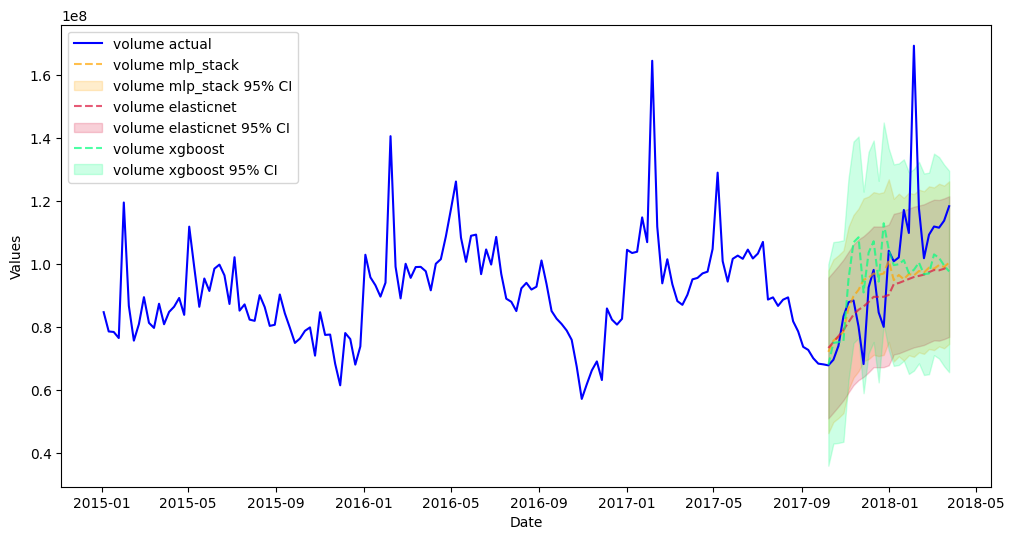

In [53]:
mvf.plot_test_set(ci=True,series='volume',put_best_on_top=True)
plt.show()

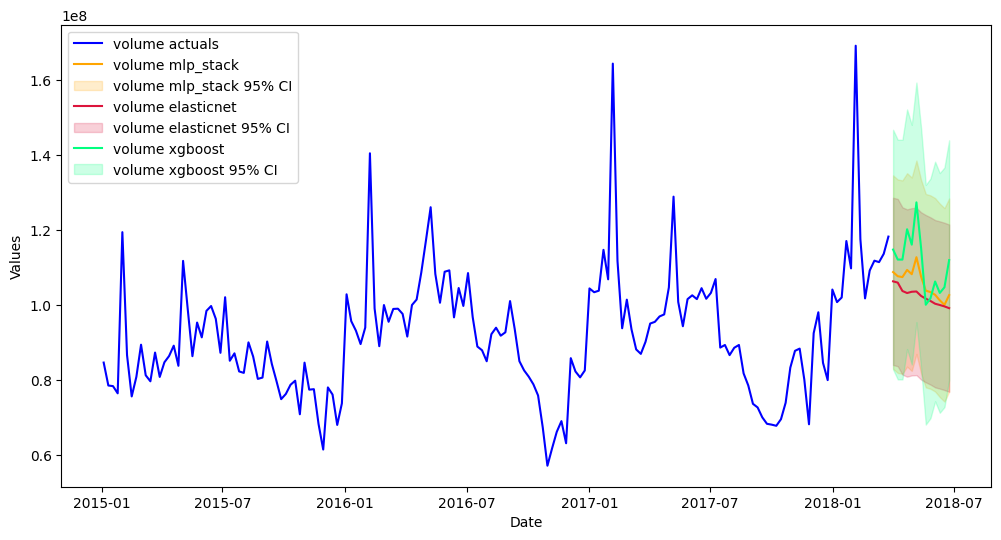

In [54]:
mvf.plot(ci=True,series='volume',put_best_on_top=True)
plt.show()

Probabalistic forecasting for creating confidence intervals is currently being worked on in the MVForecaster object, but until that is done, the backtested interval also works well:

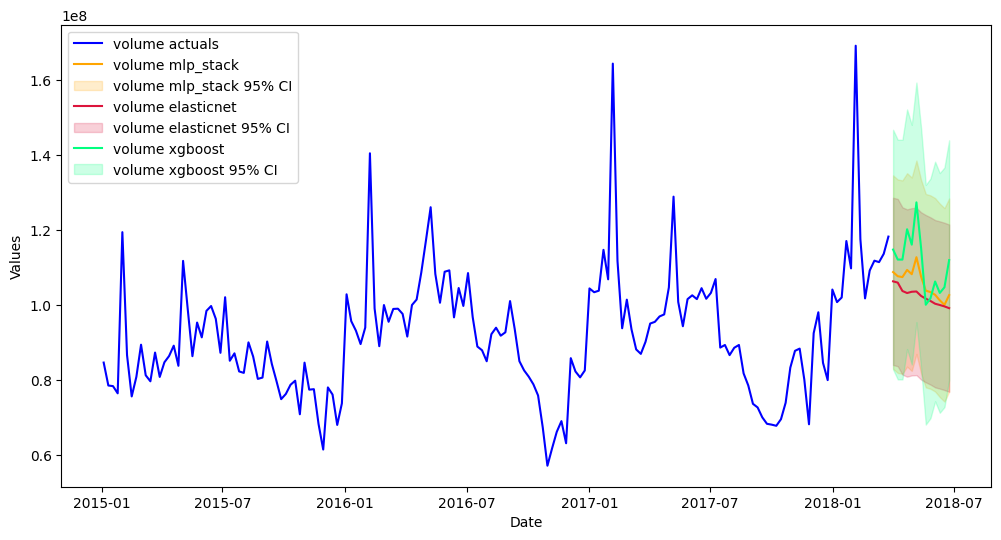

In [55]:
mvf.plot(ci=True,series='volume',put_best_on_top=True)
plt.show()

### Break Back into Forecaster Objects
- You can then add univariate models to these objects to compare with the models run multivariate.

In [56]:
from scalecast.util import break_mv_forecaster

In [57]:
fvol, fprice = break_mv_forecaster(mvf)

In [58]:
fvol

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [59]:
fprice

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    CurrentEstimator=mlr
    GridsFile=Grids
)

## Transformations
- One of the most effective way to boost forecasting power is with transformations.
- Transformations include:
  - [Log](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.LogTransform)
  - Scaling
    - [Standard](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.ScaleTransform)
    - [MinMax](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.MinMaxTransform)
  - [Differencing](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.DiffTransform)
  - [Detrending](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.DetrendTransform)
  - [Custom Functions](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.Transform)
- All transformations have a corresponding revert function.
- See the [blog post](https://medium.com/towards-data-science/time-series-transformations-and-reverting-made-easy-f4f768c18f63).

In [60]:
from scalecast.SeriesTransformer import SeriesTransformer

In [61]:
f_trans = Forecaster(y=volume,current_dates=volume.index,future_dates=13)

In [62]:
f_trans.set_test_length(.15)
f_trans.set_validation_length(13)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [63]:
transformer = SeriesTransformer(f_trans)

In [64]:
# these will all be reverted later after forecasts have been called
f_trans = transformer.DiffTransform(1)
f_trans = transformer.DiffTransform(52)
f_trans = transformer.DetrendTransform()

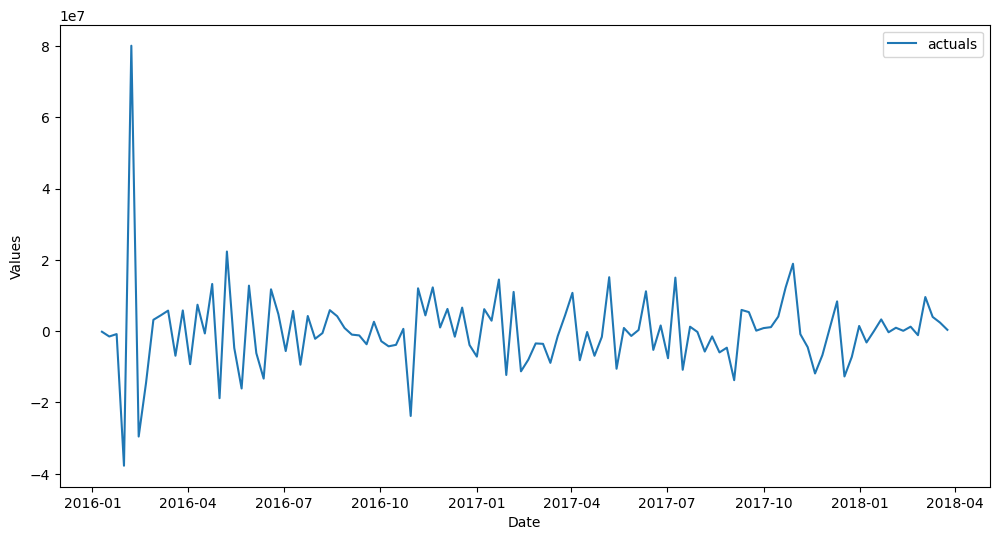

In [65]:
f_trans.plot()
plt.show()

In [66]:
f_trans.add_time_trend()
f_trans.add_seasonal_regressors('week',sincos=True,raw=False)
f_trans.add_ar_terms(13)

Forecaster(
    DateStartActuals=2016-01-10T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=116
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos', AR(lag_order=1), AR(lag_order=2), AR(lag_order=3), AR(lag_order=4), AR(lag_order=5), AR(lag_order=6), AR(lag_order=7), AR(lag_order=8), AR(lag_order=9), AR(lag_order=10), AR(lag_order=11), AR(lag_order=12), AR(lag_order=13)]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [67]:
f_trans.set_estimator('xgboost')
f_trans.manual_forecast(gamma=1,dynamic_testing=13)

[1007151.75,
 -2843174.5,
 2406933.8,
 2031899.8,
 -7832339.5,
 1566461.4,
 -2062238.5,
 -5487123.5,
 -5676481.5,
 2587060.2,
 1959740.1,
 1406064.4,
 -249488.03]

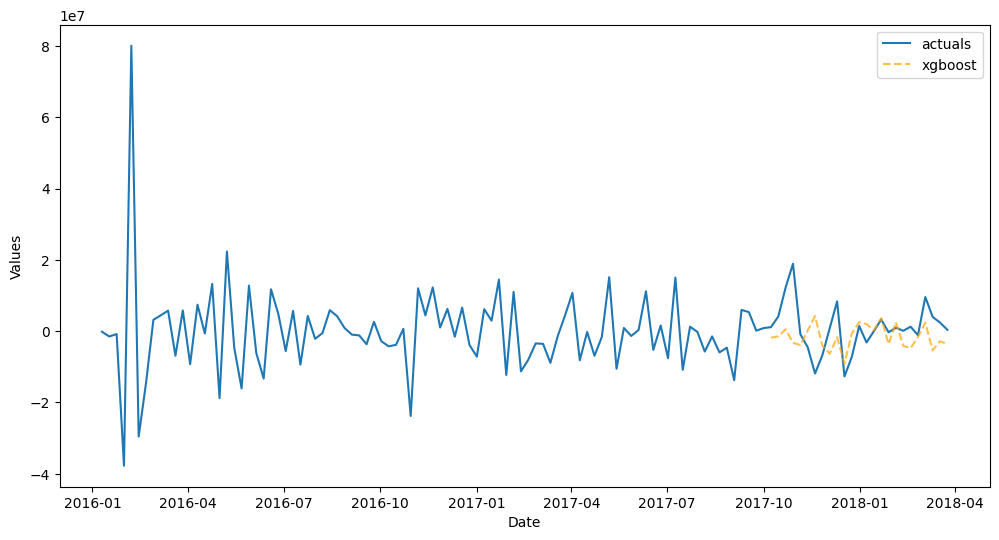

In [68]:
f_trans.plot_test_set()
plt.show()

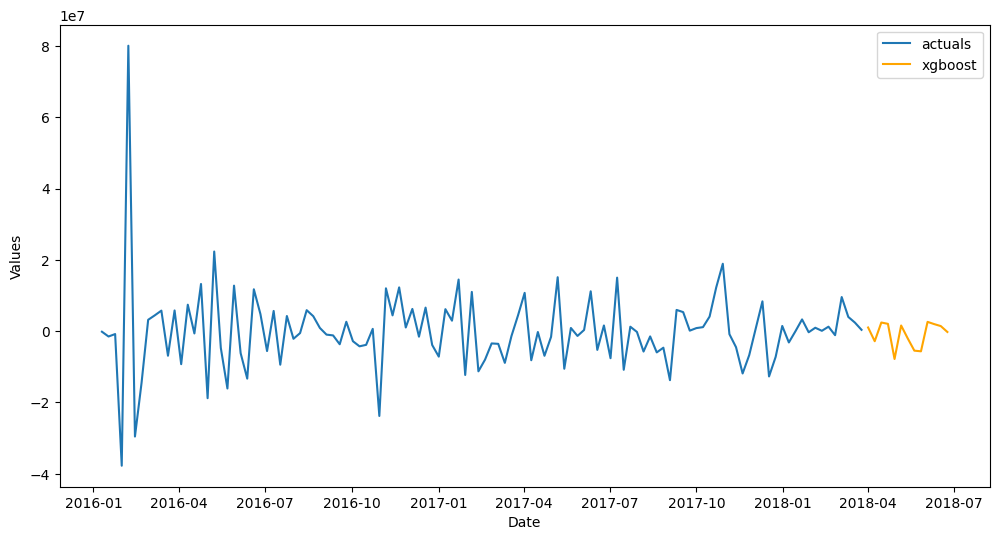

In [69]:
f_trans.plot()
plt.show()

In [70]:
# call revert functions in the opposite order as how they were called when transforming
f_trans = transformer.DetrendRevert()
f_trans = transformer.DiffRevert(52)
f_trans = transformer.DiffRevert(1)

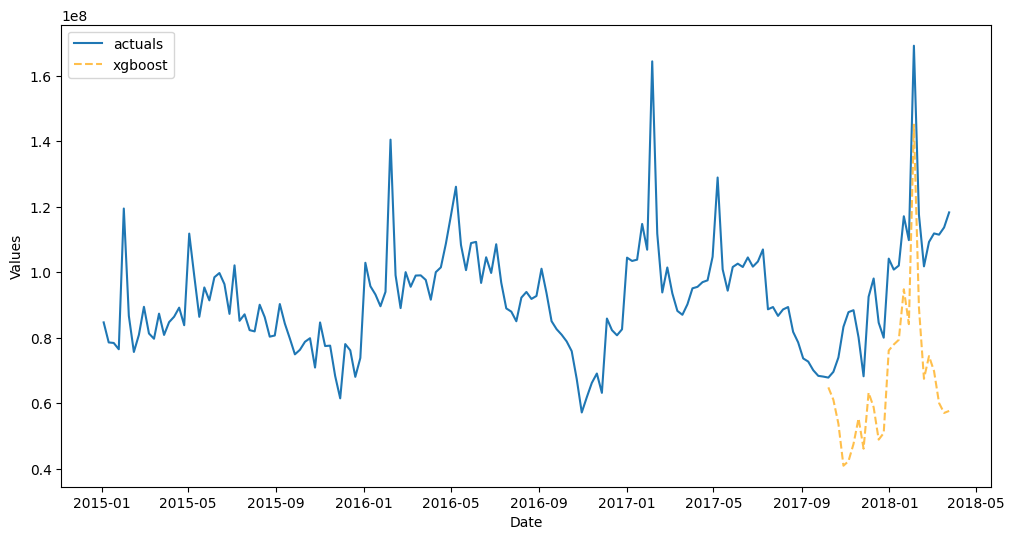

In [71]:
f_trans.plot_test_set()
plt.show()

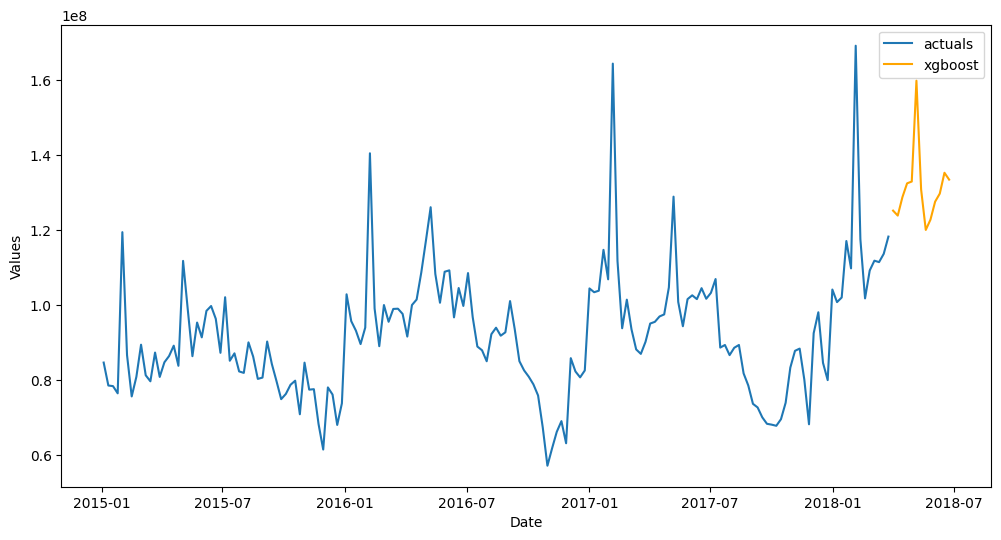

In [72]:
f_trans.plot()
plt.show()

## Pipelines
- These are objects similar to scikit-learn pipelines that offer readable and streamlined code for transforming, forecasting, and reverting.
- See the [Pipeline object documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html).

In [73]:
from scalecast.Pipeline import Transformer, Reverter, Pipeline, MVPipeline

In [74]:
f_pipe = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
f_pipe.set_test_length(.15)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [75]:
def forecaster(f):
    f.add_time_trend()
    f.add_seasonal_regressors('week',raw=False,sincos=True)
    f.add_ar_terms(13)
    f.set_estimator('catboost')
    f.manual_forecast(max_depth=2)

In [76]:
transformer = Transformer(
    transformers = [
        ('DiffTransform',1),
        ('DiffTransform',52),
        ('DetrendTransform',)
    ]
)

reverter = Reverter(
    reverters = [
        ('DetrendRevert',),
        ('DiffRevert',52),
        ('DiffRevert',1)
    ],
    base_transformer = transformer,
)

In [77]:
reverter

Reverter(
  reverters = [
    ('DetrendRevert',),
    ('DiffRevert', 52),
    ('DiffRevert', 1)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DiffTransform', 1),
    ('DiffTransform', 52),
    ('DetrendTransform',)
  ]
)
)

In [78]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f_pipe = pipeline.fit_predict(f_pipe)

Learning rate set to 0.027361
0:	learn: 8412371.7477739	total: 5.65ms	remaining: 5.65s
1:	learn: 8384243.7459151	total: 5.79ms	remaining: 2.89s
2:	learn: 8354878.6377480	total: 5.9ms	remaining: 1.96s
3:	learn: 8331905.9623156	total: 6ms	remaining: 1.49s
4:	learn: 8315602.4194521	total: 6.1ms	remaining: 1.21s
5:	learn: 8304690.5081727	total: 6.2ms	remaining: 1.03s
6:	learn: 8282164.9036867	total: 7.48ms	remaining: 1.06s
7:	learn: 8258228.5383739	total: 7.59ms	remaining: 941ms
8:	learn: 8253211.2417172	total: 7.69ms	remaining: 846ms
9:	learn: 8239703.6750241	total: 7.82ms	remaining: 774ms
10:	learn: 8223691.0991618	total: 7.91ms	remaining: 711ms
11:	learn: 8213254.2835862	total: 7.98ms	remaining: 657ms
12:	learn: 8195155.0935962	total: 8.08ms	remaining: 613ms
13:	learn: 8171928.8531482	total: 8.17ms	remaining: 575ms
14:	learn: 8134536.6237282	total: 8.24ms	remaining: 541ms
15:	learn: 8111272.7049601	total: 8.35ms	remaining: 513ms
16:	learn: 8099510.7536898	total: 8.44ms	remaining: 488ms


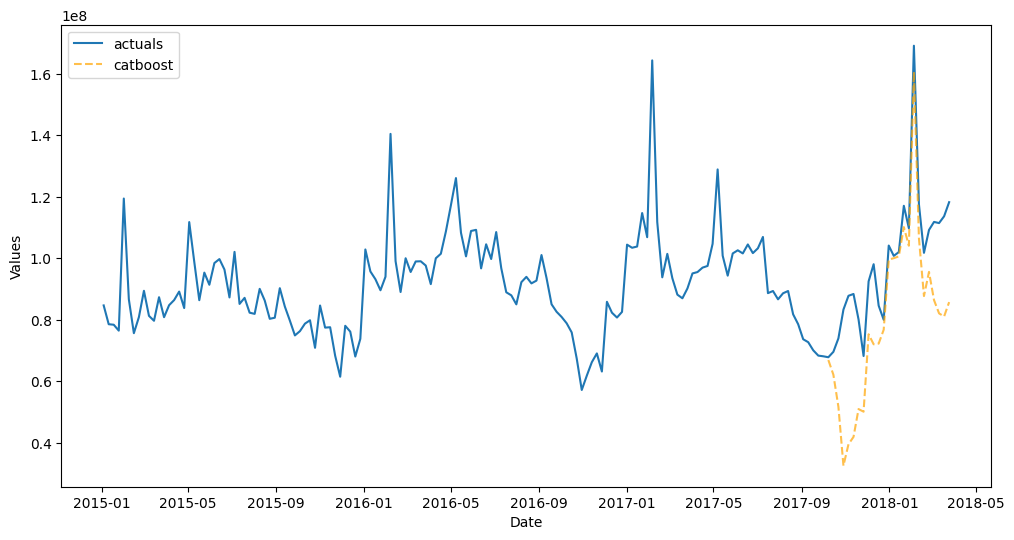

In [79]:
f_pipe.plot_test_set()
plt.show()

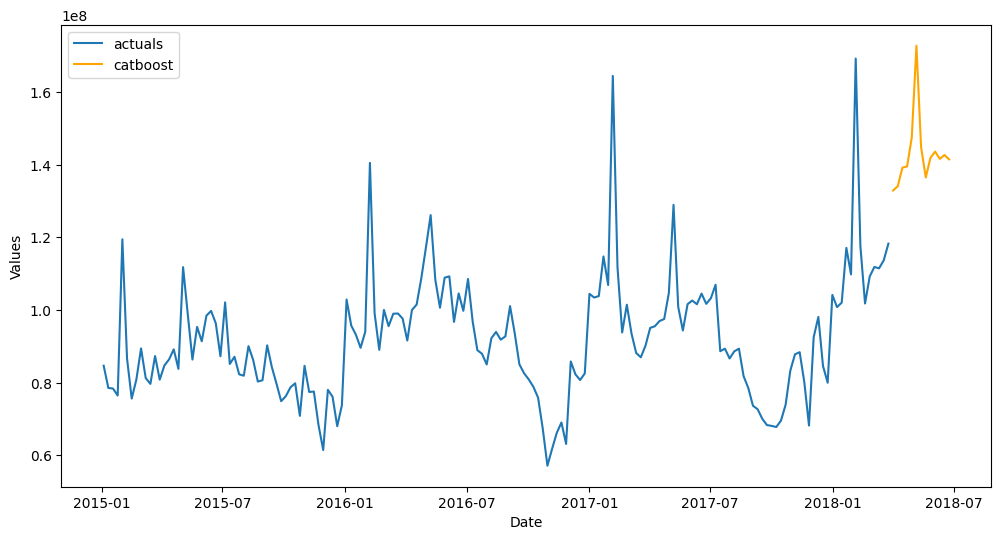

In [80]:
f_pipe.plot()
plt.show()

## Fully Automated Pipelines
- We can automate the construction of pipelines, the selection of input variables, and tuning of models with cross validation on a grid search for each model using files in the working directory called `Grids.py` for univariate forecasting and `MVGrids.py` for multivariate. Default grids can be downloaded from scalecast.

### Automated Univariate Pipelines
- [Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Pipeline)

In [81]:
from scalecast import GridGenerator
from scalecast.util import find_optimal_transformation

In [82]:
GridGenerator.get_example_grids(overwrite=True)

In [83]:
f_pipe_aut = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
f_pipe_aut.set_test_length(.15)

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [84]:
def forecaster_aut(f,models):
    f.auto_Xvar_select(
        estimator='elasticnet',
        monitor='TestSetMAE',
        alpha=0.2,
        irr_cycles = [26],
    )
    f.tune_test_forecast(
        models,
        cross_validate=True,
        k=3,
        # dynamic tuning = 13 means we will hopefully find a model that is optimized to predict 13 steps
        dynamic_tuning=13,
        dynamic_testing=13,
    )
    f.set_estimator('combo')
    f.manual_forecast()

### util.find_optimal_transformation
In this function, the following transformations are searched for:  
- Detrending  
- Box-Cox  
- First Differencing  
- Seasonal Differencing  
- Scaling  

The optimal set of transformations are returned based on best estimated out-of-sample performance on the test set. Therefore, running this function introduces leakage into the test set, but it can still be a good addition to an automated pipeline, depending on the application. Which and the order of transfomations to search through are configurable. How performance is measured, the parameters specific to a given transformation, and several other paramters are also configurable. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#module-src.scalecast.util.find_optimal_transformation).

In [85]:
transformer_aut, reverter_aut = find_optimal_transformation(
    f_pipe_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
    verbose = True,
) # returns a Transformer and Reverter object that can be plugged into a larger pipeline

Using elasticnet model to find the best transformation set on 3 test sets, each 13 in length.
All transformation tries will be evaluated with 13 lags.
Last transformer tried:
[]
Score (mae): 17933061.20374991
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (mae): 23964157.165726677
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (mae): 17174376.36667074
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (mae): 24467364.037869632
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (mae): 11573053.4258074
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, '

In [86]:
pipeline_aut = Pipeline(
    steps = [
        ('Transform',transformer_aut),
        ('Forecast',forecaster_aut),
        ('Revert',reverter_aut),
    ]
)

f_pipe_aut = pipeline_aut.fit_predict(
    f_pipe_aut,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'knn',
    ],
)

In [87]:
f_pipe_aut

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[AR(lag_order=1), AR(lag_order=2), AR(lag_order=3), AR(lag_order=4), AR(lag_order=5)]
    TestLength=25
    ValidationMetric=rmse
    ForecastsEvaluated=['mlr', 'elasticnet', 'xgboost', 'knn', 'combo']
    CILevel=None
    CurrentEstimator=combo
    GridsFile=Grids
)

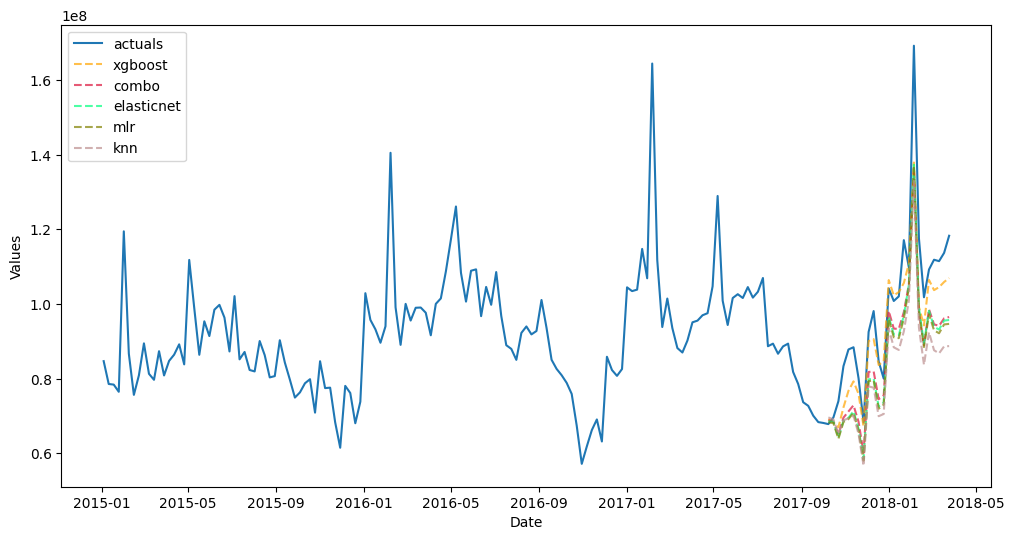

In [88]:
f_pipe_aut.plot_test_set(order_by='TestSetRMSE')
plt.show()

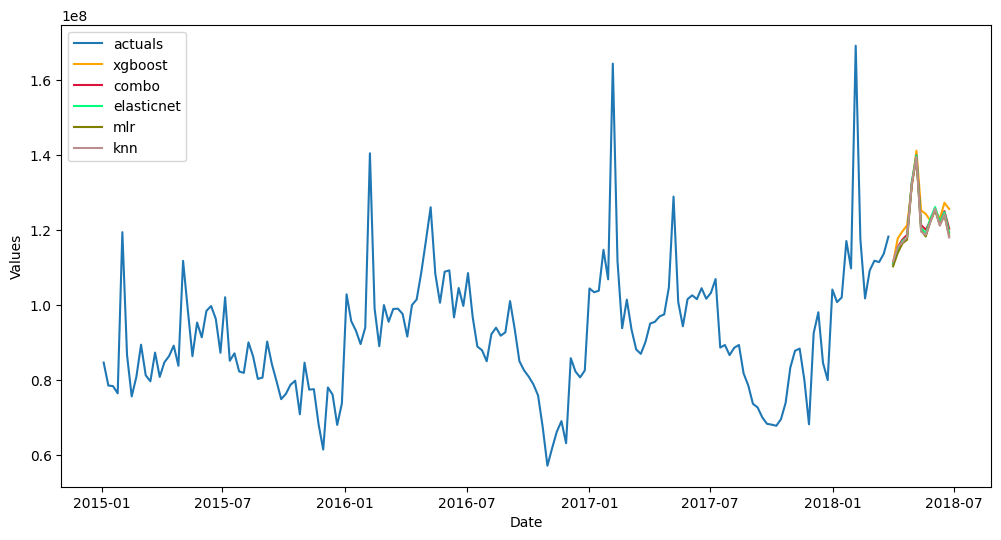

In [89]:
f_pipe_aut.plot(order_by='TestSetRMSE')
plt.show()

### Backtest Univariate Pipeline

You may be interested to know beyond a single test-set metric, how well your pipeline performs out-of-sample. Backtesting can help answer that by iterating through the entire pipeline several times and testing the procedure each time. It can also help make [expanding confidence intervals](https://scalecast-examples.readthedocs.io/en/latest/misc/cis-bt/cis-bt.html). See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Pipeline.backtest).

In [90]:
from scalecast.util import backtest_metrics

In [91]:
uv_backtest_results = pipeline_aut.backtest(
    f_pipe_aut,
    n_iter = 3,
    jump_back = 13,
    cis = False,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'knn',
    ],
)

After obtaining the results from the backtest, we can see the average performance over each iteration using the `util.backtest_metrics` function. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#module-src.scalecast.util.backtest_metrics).

In [92]:
pd.options.display.float_format = '{:,.4f}'.format
backtest_metrics(
    uv_backtest_results,
    mets=['smape','rmse','bias'],
)

Iter0             Iter1            Iter2  \
Model      Metric                                                        
mlr        smape             0.1130            0.2317           0.1142   
           rmse     15,488,744.6687   19,538,227.8474  11,910,709.6294   
           bias   -165,115,026.5519 -207,268,257.9220 103,757,419.3938   
elasticnet smape             0.1139            0.1962           0.1428   
           rmse     15,637,578.9398   16,625,313.2954  14,338,412.2989   
           bias   -166,295,878.6389 -169,974,287.0231 145,808,728.0805   
xgboost    smape             0.1559            0.1151           0.1475   
           rmse     19,082,290.7304   11,550,757.8633  15,191,141.5574   
           bias   -219,935,081.0966 -103,119,659.0546 147,885,368.4947   
knn        smape             0.1568            0.1896           0.1439   
           rmse     19,855,895.0761   16,441,684.0561  14,418,665.8740   
           bias   -220,650,230.0243 -174,089,027.5994 145,204,593.3703   
combo      smape             0.1344            0.1805           0.1366   
           rmse     17,371,835.8070   15,768,729.5254  13,916,077.0709   
           bias   -192,999,054.0779 -163,612,807.8998 135,664,027.3348   

                           Average  
Model      Metric                   
mlr        smape            0.1529  
           rmse    15,645,894.0485  
           bias   -89,541,955.0267  
elasticnet smape            0.1510  
           rmse    15,533,768.1780  
           bias   -63,487,145.8605  
xgboost    smape            0.1395  
           rmse    15,274,730.0504  
           bias   -58,389,790.5522  
knn        smape            0.1635  
           rmse    16,905,415.0021  
           bias   -83,178,221.4178  
combo      smape            0.1505  
           rmse    15,685,547.4678  
           bias   -73,649,278.2143

### Automated Multivariate Pipelines
- See the [MVPipeline object documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.MVPipeline).

In [93]:
GridGenerator.get_mv_grids(overwrite=True)

In [94]:
fvol_aut = Forecaster(
    y=volume,
    current_dates=volume.index,
    future_dates=13,
    test_length = .15,
)
fprice_aut = Forecaster(
    y=price,
    current_dates=price.index,
    future_dates=13,
    test_length = .15,
)

In [95]:
def add_vars(f,**kwargs):
    f.add_seasonal_regressors(
        'month',
        'quarter',
        'week',
        raw=False,
        sincos=True
    )

def mvforecaster(mvf,models):
    mvf.set_optimize_on('volume')
    mvf.tune_test_forecast(
        models,
        cross_validate=True,
        k=2,
        rolling=True,
        dynamic_tuning=13,
        dynamic_testing=13,
        limit_grid_size = .2,
        error = 'warn',
    )

In [96]:
transformer_vol, reverter_vol = find_optimal_transformation(
    fvol_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
    verbose = True,
)

Using elasticnet model to find the best transformation set on 3 test sets, each 13 in length.
All transformation tries will be evaluated with 13 lags.
Last transformer tried:
[]
Score (mae): 17933061.20374991
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (mae): 23964157.165726677
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (mae): 17174376.36667074
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (mae): 24467364.037869632
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (mae): 11573053.4258074
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, '

In [97]:
transformer_price, reverter_price = find_optimal_transformation(
    fprice_aut,
    lags = 13,
    m = 52,
    monitor = 'mae',
    estimator = 'elasticnet',
    alpha = 0.2,
    test_length = 13,
    num_test_sets = 3,
    space_between_sets = 4,
    verbose = True,
)

Using elasticnet model to find the best transformation set on 3 test sets, each 13 in length.
All transformation tries will be evaluated with 13 lags.
Last transformer tried:
[]
Score (mae): 0.06804292152560591
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (mae): 0.3531129223321485
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (mae): 0.1865457226698867
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 2})]
Score (mae): 0.4079071208348249
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (mae): 0.04226554848615104
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'}), ('Transform', BoxcoxTransform, {'lmbda': -0.5})]
Score (mae

In [98]:
mvpipeline = MVPipeline(
    steps = [
        ('Transform',[transformer_vol,transformer_price]),
        ('Add Xvars',[add_vars]*2),
        ('Forecast',mvforecaster),
        ('Revert',[reverter_vol,reverter_price]),
    ],
    test_length = 20,
    cis = True,
    names = ['volume','price'],
)

fvol_aut, fprice_aut = mvpipeline.fit_predict(
    fvol_aut, 
    fprice_aut,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
    ],
) # returns a tuple of Forecaster objects

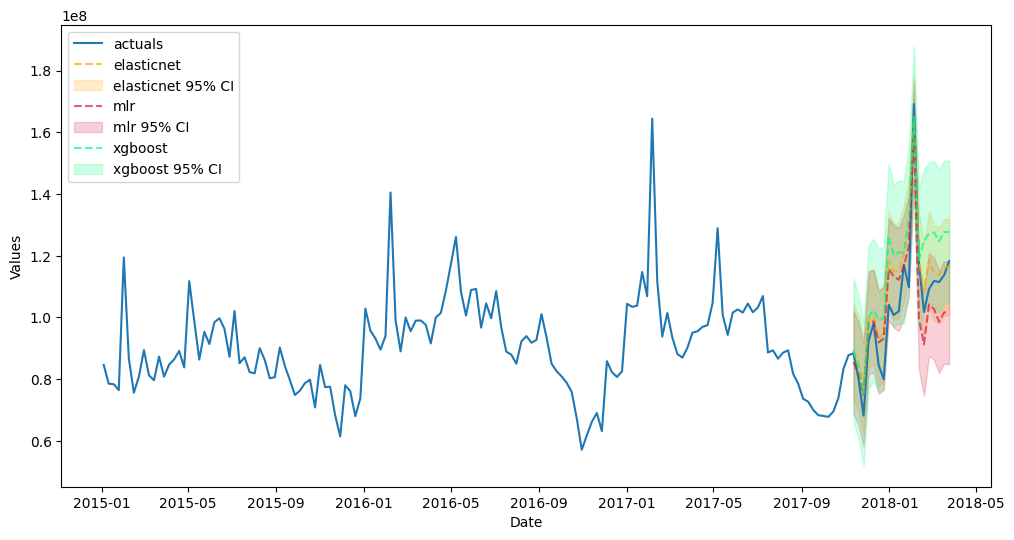

In [99]:
fvol_aut.plot_test_set(order_by='TestSetRMSE',ci=True)
plt.show()

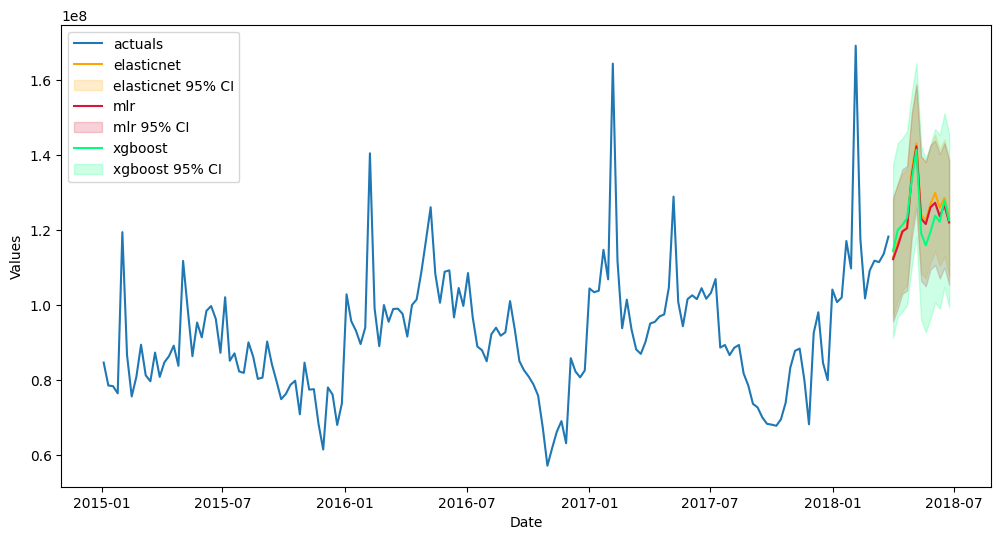

In [100]:
fvol_aut.plot(order_by='TestSetRMSE',ci=True)
plt.show()

### Backtest Multivariate Pipeline

Like univariate pipelines, multivariate pipelines can also be backtested. Info about each model and series becomes possible to compare. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.MVPipeline.backtest).

In [101]:
# recreate Forecaster objects to bring dates back lost from taking seasonal differences
fvol_aut = Forecaster(
    y=volume,
    current_dates=volume.index,
    future_dates=13,
)
fprice_aut = Forecaster(
    y=price,
    current_dates=price.index,
    future_dates=13,
)

In [102]:
mv_backtest_results = mvpipeline.backtest(
    fvol_aut, 
    fprice_aut,
    n_iter = 3,
    jump_back = 13,
    test_length = 0,
    cis = False,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
    ],
)

In [103]:
backtest_metrics(
    mv_backtest_results,
    mets=['smape','rmse','bias'],
    names = ['Volume','Price'],
)

Iter0             Iter1            Iter2  \
Series Model      Metric                                                        
Volume mlr        smape             0.0544            0.1176           0.2057   
                  rmse      9,607,094.0998   10,760,756.5431  21,194,845.9046   
                  bias    -69,742,732.2955  -87,711,912.7603 225,572,934.0685   
       elasticnet smape             0.1132            0.1520           0.1848   
                  rmse     15,469,688.0995   13,489,283.4983  18,735,196.1611   
                  bias   -161,064,422.2044 -129,692,075.0240 201,475,912.8808   
       xgboost    smape             0.1191            0.2939           0.1246   
                  rmse     18,209,258.9671   23,461,672.8655  11,985,763.1052   
                  bias    182,117,839.7003 -243,842,453.2343 130,112,456.3580   
Price  mlr        smape             0.0523            0.0762           0.0813   
                  rmse              0.0811            0.1307           0.1795   
                  bias              0.9321            1.0663          -1.5524   
       elasticnet smape             0.0281            0.0747           0.1073   
                  rmse              0.0446            0.1261           0.2228   
                  bias             -0.1796            0.9811          -2.2912   
       xgboost    smape             0.0685            0.0519           0.0799   
                  rmse              0.1042            0.1086           0.1707   
                  bias              1.2319           -0.3951          -1.6163   

                                  Average  
Series Model      Metric                   
Volume mlr        smape            0.1259  
                  rmse    13,854,232.1825  
                  bias    22,706,096.3376  
       elasticnet smape            0.1500  
                  rmse    15,898,055.9196  
                  bias   -29,760,194.7825  
       xgboost    smape            0.1792  
                  rmse    17,885,564.9793  
                  bias    22,795,947.6080  
Price  mlr        smape            0.0700  
                  rmse             0.1304  
                  bias             0.1487  
       elasticnet smape            0.0700  
                  rmse             0.1312  
                  bias            -0.4966  
       xgboost    smape            0.0668  
                  rmse             0.1278  
                  bias            -0.2598

Through backtesting, we can see that the multivariate approach out-performed the univariate approach. Very cool!

## Scaled Automated Forecasting
- We can scale the fully automated approach to many series where we can then access all results through plotting with Jupyter widgets and export functions.
- We produce a separate forecast for avocado sales in each region in our dataset.
- This is done with a univariate approach, but cleverly using the code in this notebook, it could be transformed into a multivariate process where volume and price are forecasted together.

In [104]:
from scalecast.notebook import results_vis
from tqdm.notebook import tqdm

In [105]:
def forecaster_scaled(f,models):
    f.auto_Xvar_select(
        estimator='elasticnet',
        monitor='TestSetMAE',
        alpha=0.2,
        irr_cycles = [26],
    )
    f.tune_test_forecast(
        models,
        dynamic_testing=13,
    )
    f.set_estimator('combo')
    f.manual_forecast()

In [106]:
results_dict = {}
for region in tqdm(data.region.unique()):
    series = data.loc[data['region'] == region].groupby('Date')['Total Volume'].sum()
    f_i = Forecaster(
        y = series,
        current_dates = series.index,
        future_dates = 13,
        test_length = .15,
        validation_length = 13,
        cis = True,
    )
    transformer_i, reverter_i = find_optimal_transformation(
        f_i,
        lags = 13,
        m = 52,
        monitor = 'mae',
        estimator = 'elasticnet',
        alpha = 0.2,
        test_length = 13,
    )
    pipeline_i = Pipeline(
        steps = [
            ('Transform',transformer_i),
            ('Forecast',forecaster_scaled),
            ('Revert',reverter_i),
        ]
    )
    f_i = pipeline_i.fit_predict(
        f_i,
        models=[
            'mlr',
            'elasticnet',
            'xgboost',
            'knn',
        ],
    )
    results_dict[region] = f_i

  0%|          | 0/54 [00:00<?, ?it/s]

Run the next two functions locally to see the full functionality of these widgets.

In [107]:
results_vis(results_dict,'test')

Dropdown(description='Time Series:', options=('Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', '…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5), value=1)

SelectMultiple(description='Exclude', options=('mlr', 'elasticnet', 'xgboost', 'knn', 'combo'), value=())

Dropdown(description='View Confidence Intervals', options=(False, True), value=False)

Dropdown(description='Order By', index=7, options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE'…

Button(description='Select Time Series', style=ButtonStyle())

Output()

In [108]:
results_vis(results_dict)

Dropdown(description='Time Series:', options=('Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', '…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5), value=1)

SelectMultiple(description='Exclude', options=('mlr', 'elasticnet', 'xgboost', 'knn', 'combo'), value=())

Dropdown(description='View Confidence Intervals', options=(False, True), value=False)

Dropdown(description='Order By', index=7, options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE'…

Button(description='Select Time Series', style=ButtonStyle())

Output()

## Exporting Results

In [109]:
from scalecast.multiseries import export_model_summaries

### Exporting Results from a Single `Forecaster` Object

In [110]:
results = f.export(cis=True,models=['mlr','lasso','ridge'])
results.keys()

dict_keys(['model_summaries', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [111]:
for k, df in results.items():
    print(f'{k} has these columns:',*df.columns,'-'*25,sep='\n')

model_summaries has these columns:
ModelNickname
Estimator
Xvars
HyperParams
Observations
DynamicallyTested
TestSetLength
CILevel
ValidationMetric
models
weights
best_model
TestSetRMSE
TestSetR2
TestSetMAE
TestSetMAPE
InSampleRMSE
InSampleR2
InSampleMAE
InSampleMAPE
-------------------------
lvl_fcsts has these columns:
DATE
mlr
mlr_upperci
mlr_lowerci
lasso
lasso_upperci
lasso_lowerci
ridge
ridge_upperci
ridge_lowerci
-------------------------
lvl_test_set_predictions has these columns:
DATE
actual
mlr
mlr_upperci
mlr_lowerci
lasso
lasso_upperci
lasso_lowerci
ridge
ridge_upperci
ridge_lowerci
-------------------------


In [112]:
results['model_summaries'][['ModelNickname','HyperParams','TestSetRMSE','InSampleRMSE']]

,ModelNickname,HyperParams,TestSetRMSE,InSampleRMSE
0,mlr,{},"16,818,489.5277","10,231,495.9303"
0,lasso,{'alpha': 0.2},"16,818,489.9828","10,231,495.9303"
0,ridge,{'alpha': 0.2},"16,827,165.4875","10,265,352.0145"


Other export functions:  
[Forecaster.export_Xvars_df](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_Xvars_df)   
[Forecaster.export_feature_importance](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_feature_importance)  
[Forecaster.export_fitted_vals](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_fitted_vals)  
[Forecaster.export_summary_stats](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_summary_stats)  
[Forecaster.export_validation_grid](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_validation_grid)  

Other plotting functions:  
[Forecaster.plot_fitted](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.plot_fitted)  
[Forecaster.plot_periodogram](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.plot_periodogram)  

### Exporting Results from a Single `MVForecaster` Object

In [113]:
mvresults = mvf.export(cis=True,models=['elasticnet','xgboost'])
mvresults.keys()

dict_keys(['model_summaries', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [114]:
for k, df in mvresults.items():
    print(f'{k} has these columns:',*df.columns,'-'*25,sep='\n')

model_summaries has these columns:
Series
ModelNickname
Estimator
Xvars
HyperParams
Lags
Observations
DynamicallyTested
TestSetLength
ValidationMetric
ValidationMetricValue
OptimizedOn
best_model
MetricOptimized
TestSetRMSE
TestSetR2
TestSetMAE
TestSetMAPE
InSampleRMSE
InSampleR2
InSampleMAE
InSampleMAPE
-------------------------
lvl_fcsts has these columns:
DATE
volume_elasticnet_lvl_fcst
volume_elasticnet_lvl_fcst_upper
volume_elasticnet_lvl_fcst_lower
volume_xgboost_lvl_fcst
volume_xgboost_lvl_fcst_upper
volume_xgboost_lvl_fcst_lower
price_elasticnet_lvl_fcst
price_elasticnet_lvl_fcst_upper
price_elasticnet_lvl_fcst_lower
price_xgboost_lvl_fcst
price_xgboost_lvl_fcst_upper
price_xgboost_lvl_fcst_lower
-------------------------
lvl_test_set_predictions has these columns:
DATE
volume_actuals
volume_elasticnet_lvl_ts
volume_elasticnet_lvl_ts_upper
volume_elasticnet_lvl_ts_lower
volume_xgboost_lvl_ts
volume_xgboost_lvl_ts_upper
volume_xgboost_lvl_ts_lower
price_actuals
price_elasticnet_

In [115]:
mvresults['model_summaries'][['Series','ModelNickname','HyperParams','Lags','TestSetRMSE','InSampleRMSE']]

,Series,ModelNickname,HyperParams,Lags,TestSetRMSE,InSampleRMSE
0,volume,elasticnet,NaN,13,"18,694,896.5159","11,976,031.0554"
0,volume,xgboost,NaN,13,"19,925,832.7824",42.9037
0,price,elasticnet,NaN,13,0.1522,0.1561
0,price,xgboost,NaN,13,0.1288,0.1129


Other export functions:  
[Forecaster.export_fitted_vals](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_fitted_vals)   
[Forecaster.export_validation_grid](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_validation_grid)  

Other plotting functions:  
[MVForecaster.plot_fitted](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.plot_fitted)  

### Exporting Results from a Dictionary of `Forecaster` Objects

In [116]:
all_results = export_model_summaries(results_dict)
all_results[['ModelNickname','Series','Xvars','HyperParams','TestSetRMSE','InSampleRMSE']].sample(10)

,ModelNickname,Series,Xvars,HyperParams,TestSetRMSE,InSampleRMSE
83,knn,HarrisburgScranton,"[AR(lag_order=1), AR(lag_order=2), AR(lag_orde...",{'n_neighbors': 4},"164,430.0520","154,146.1304"
95,mlr,Indianapolis,"[t, AR(lag_order=1), AR(lag_order=2), AR(lag_o...",{'normalizer': None},"56,581.4483","58,173.5560"
261,elasticnet,West,"[weeksin, weekcos, AR(lag_order=1), AR(lag_ord...","{'alpha': 0.7, 'l1_ratio': 0.75, 'normalizer':...","995,570.2075","702,011.8657"
43,knn,Chicago,"[AR(lag_order=1), AR(lag_order=2), AR(lag_orde...",{'n_neighbors': 35},"103,525.9785","475,201.8170"
31,elasticnet,California,"[AR(lag_order=1), AR(lag_order=2), AR(lag_orde...","{'alpha': 0.1, 'l1_ratio': 0.25, 'normalizer':...","1,218,963.8795","770,507.6049"
232,xgboost,Southeast,[AR(lag_order=1)],"{'n_estimators': 250, 'scale_pos_weight': 5, '...","1,620,922.2236","335,326.5507"
108,knn,LasVegas,"[t, AR(lag_order=1), AR(lag_order=2), AR(lag_o...",{'n_neighbors': 88},"32,914.2895","37,645.7892"
207,xgboost,SanDiego,"[AR(lag_order=1), AR(lag_order=2), AR(lag_orde...","{'n_estimators': 150, 'scale_pos_weight': 5, '...","131,496.3218","105,493.4193"
75,mlr,GreatLakes,"[weeksin, weekcos, monthsin, monthcos, AR(lag_...",{'normalizer': 'minmax'},"568,296.6779","1,108,303.8002"
63,knn,Denver,"[weeksin, weekcos, AR(lag_order=1), AR(lag_ord...",{'n_neighbors': 5},"124,364.0781","76,749.2221"
